## Overview
This tutorial has been prepared by Alex Bonnet, ML Solutions Engineer @ Encord - you might also be interested in checking out our open-source framework for computer vision model testing, evaluation, and validation that you can find here https://github.com/encord-team/encord-active).

This is the notebook which implements the steps discussed in this blog post: https://encord.com/blog/learn-how-to-fine-tune-the-segment-anything-model-sam/

The aim is to take Segment Anything Model and fine tune it to a specific application. We are going to be using the stamp verification dataset https://www.kaggle.com/datasets/rtatman/stamp-verification-staver-dataset since it has data SAM is unlikely to have seen (scans of invoices with stamps), has precise ground truth segmentation masks and also has bounding boxes which we can use as prompts to SAM.

## Set up

In [1]:
# ! pip install kaggle &> /dev/null
# ! pip install torch torchvision &> /dev/null
# ! pip install opencv-python pycocotools matplotlib onnxruntime onnx &> /dev/null
# # ! pip install git+https://github.com/facebookresearch/segment-anything.git &> /dev/null
# ! wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth &> /dev/null

^C


**Action Required:** Place your kaggle.json file into the files in the notebook workspace. More info here https://github.com/Kaggle/kaggle-api#api-credentials

In [ ]:
# ! mkdir ~/.kaggle
# ! mv kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# ! kaggle datasets download rtatman/stamp-verification-staver-dataset

In [ ]:
# ! unzip stamp-verification-staver-dataset.zip &> /dev/null

In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import cv2
from preprocess import get_bbox_coords, get_bounding_box, get_ground_truth_masks, preprocess

## Preprocess data

We extract the bounding box coordinates which will be used to feed into SAM as prompts.

In [3]:
dataset_dir = '/root/ai/dataset/mask_1513/'
bbox_coords = get_bbox_coords(dataset_dir)
ground_truth_masks = get_ground_truth_masks(bbox_coords, dataset_dir)

len(bbox_coords.keys()) : 1512
len(ground_truth_masks.keys()) : 1512


In [11]:
ground_truth_masks.keys()
print(ground_truth_masks["Type6_iter111_jpg.rf.026f7a76d82cceaae852dd69283c1a0c"])

[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [6]:
print(bbox_coords)

{'32_jpeg.rf.77d909cd7585dad1cdb07328f7867f6e': array([239, 195, 440, 377]), '120_jpeg.rf.9210a475815ce6b942983a91fd58d72e': array([171, 421, 438, 611]), '436_jpeg.rf.6c9f6efe0ab134a3444ed592655fcaac': array([188, 125, 463, 447]), '230_jpeg.rf.cdae45e0f738df552e5aea9fbc783c0e': array([  0,   0, 640, 457]), '480_jpeg.rf.779231e00f78fa1c933c3e24c5096327': array([296, 331, 447, 416]), '20_jpeg.rf.d69873bb21e62cec6cba108dbb8f944b': array([190, 145, 446, 474]), '579_jpeg.rf.ba33271514ec547d4b3d9518cf3cb72d': array([ 56, 343, 566, 587]), '131_jpeg.rf.05314c3708da7647bf68e0b469f1495c': array([ 31, 299, 577, 630]), '347_jpeg.rf.e5a077c9182722970ce5013b51646bb4': array([  0, 178, 590, 586]), '222_jpeg.rf.85993d0c20b17771205974133a310d28': array([121, 162, 511, 451]), '143_jpeg.rf.c0c72d3d27a92c4812f39c885824154f': array([148, 133, 457, 640]), '47_jpeg.rf.4a1313195eb0ee7c258be4bb51a62c8d': array([281, 163, 386, 297]), '540_jpeg.rf.052e43d0a6f39abd429e3860232a4677': array([ 88, 136, 525, 496]), '

We extract the ground truth segmentation masks

## Take a look at the images, the bounding box prompts and the ground truth segmentation masks

In [4]:
# Helper functions provided in https://github.com/facebookresearch/segment-anything/blob/9e8f1309c94f1128a6e5c047a10fdcb02fc8d651/notebooks/predictor_example.ipynb
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

We can see here that the ground truth mask is extremely tight which will be good for calculating an accurate loss.
The bounding box overlaid will be a good prompt.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


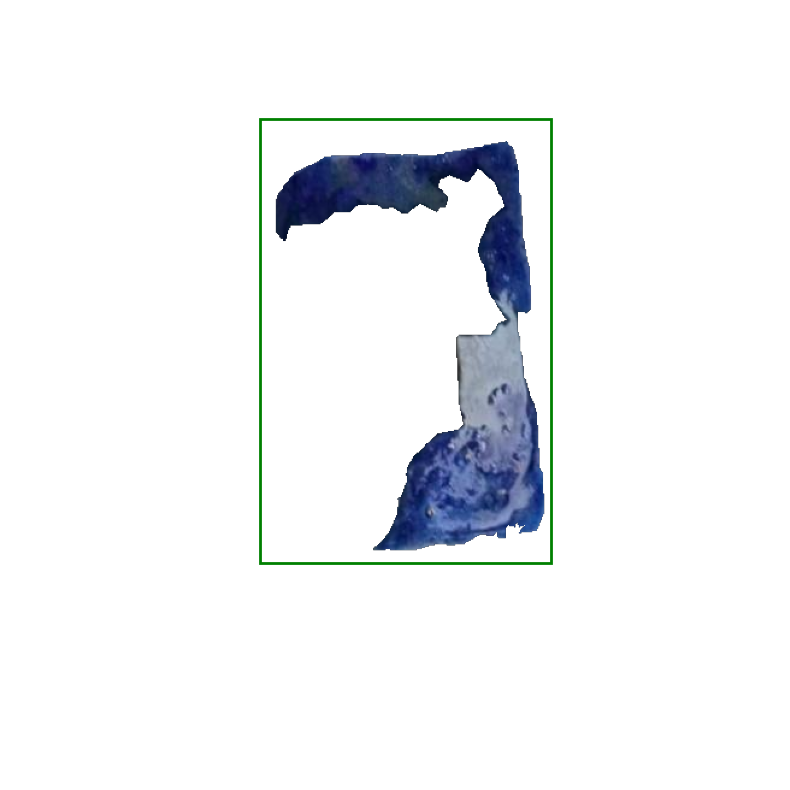

In [6]:
name = 'Type7_iter34_jpg.rf.a4abbe0c6386d4d75f6fd213e80f483c'
image = cv2.imread(dataset_dir+f'{name}.jpg')

plt.figure(figsize=(10,10))
plt.imshow(image)
show_box(bbox_coords[name], plt.gca())
show_mask(ground_truth_masks[name], plt.gca())
plt.axis('off')
plt.show()

## Prepare Fine Tuning

In [9]:
model_type = 'vit_b'
checkpoint = '/root/ai/weights/sam_vit_b_01ec64.pth'
device = 'cuda:0'

In [10]:
from segment_anything import SamPredictor, sam_model_registry
sam_model = sam_model_registry[model_type](checkpoint=checkpoint)
sam_model.to(device)
sam_model.train();

We convert the input images into a format SAM's internal functions expect.

In [11]:
# Preprocess the images
from collections import defaultdict

import torch

transformed_data, transform = preprocess(sam_model, bbox_coords, device, dataset_dir)

make transformed_data


In [17]:
for i, k in enumerate(transformed_data.keys()):
    if i == 0:
        print(transformed_data[k]['image'].shape)
        print(transformed_data[k]['input_size'])
        print(transformed_data[k]['original_image_size'])
    else:
        break

torch.Size([1, 3, 1024, 1024])
(1024, 1024)
(640, 640)


In [18]:
# Set up the optimizer, hyperparameter tuning will improve performance here
lr = 1e-4
wd = 0
optimizer = torch.optim.Adam(sam_model.mask_decoder.parameters(), lr=lr, weight_decay=wd)

loss_fn = torch.nn.MSELoss()
# loss_fn = torch.nn.BCELoss()
keys = list(bbox_coords.keys())

## Run fine tuning

In [19]:
from statistics import mean

from tqdm import tqdm
from torch.nn.functional import threshold, normalize

num_epochs = 100
losses = []

for epoch in range(num_epochs):
  epoch_losses = []
  # Just train on the first 20 examples
  for k in keys[:20]:
    input_image = transformed_data[k]['image'].to(device)
    input_size = transformed_data[k]['input_size']
    original_image_size = transformed_data[k]['original_image_size']

    # No grad here as we don't want to optimise the encoders
    with torch.no_grad():
      image_embedding = sam_model.image_encoder(input_image)

      prompt_box = bbox_coords[k]
      box = transform.apply_boxes(prompt_box, original_image_size)
      box_torch = torch.as_tensor(box, dtype=torch.float, device=device)
      box_torch = box_torch[None, :]

      sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
          points=None,
          boxes=box_torch,
          masks=None,
      )
    low_res_masks, iou_predictions = sam_model.mask_decoder(
      image_embeddings=image_embedding,
      image_pe=sam_model.prompt_encoder.get_dense_pe(),
      sparse_prompt_embeddings=sparse_embeddings,
      dense_prompt_embeddings=dense_embeddings,
      multimask_output=False,
    )

    upscaled_masks = sam_model.postprocess_masks(low_res_masks, input_size, original_image_size).to(device)
    binary_mask = normalize(threshold(upscaled_masks, 0.0, 0))

    gt_mask_resized = torch.from_numpy(np.resize(ground_truth_masks[k], (1, 1, ground_truth_masks[k].shape[0], ground_truth_masks[k].shape[1]))).to(device)
    gt_binary_mask = torch.as_tensor(gt_mask_resized > 0, dtype=torch.float32)

    loss = loss_fn(binary_mask, gt_binary_mask)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    epoch_losses.append(loss.item())
  losses.append(epoch_losses)
  print(f'EPOCH: {epoch}')
  print(f'Mean loss: {mean(epoch_losses)}')

EPOCH: 0
Mean loss: 0.927214577794075
EPOCH: 1
Mean loss: 0.9269822746515274
EPOCH: 2
Mean loss: 0.9461031258106232
EPOCH: 3
Mean loss: 0.9573408007621765
EPOCH: 4
Mean loss: 0.9542255610227585
EPOCH: 5
Mean loss: 0.9567093312740326
EPOCH: 6
Mean loss: 0.9594395577907562
EPOCH: 7
Mean loss: 0.9541873574256897
EPOCH: 8
Mean loss: 0.9195944637060165
EPOCH: 9
Mean loss: 0.8980662643909454
EPOCH: 10
Mean loss: 0.8936423122882843
EPOCH: 11
Mean loss: 0.8883477598428726
EPOCH: 12
Mean loss: 0.8881280273199081
EPOCH: 13
Mean loss: 0.9145374536514282
EPOCH: 14
Mean loss: 0.9404211193323135
EPOCH: 15
Mean loss: 0.9434251517057419
EPOCH: 16
Mean loss: 0.9391252189874649
EPOCH: 17
Mean loss: 0.9392608404159546
EPOCH: 18
Mean loss: 0.9547077476978302
EPOCH: 19
Mean loss: 0.9709139257669449
EPOCH: 20
Mean loss: 0.9745839655399322
EPOCH: 21
Mean loss: 0.9583154052495957
EPOCH: 22
Mean loss: 0.9454339444637299
EPOCH: 23
Mean loss: 0.924500098824501
EPOCH: 24
Mean loss: 0.8938040614128113
EPOCH: 25
Me

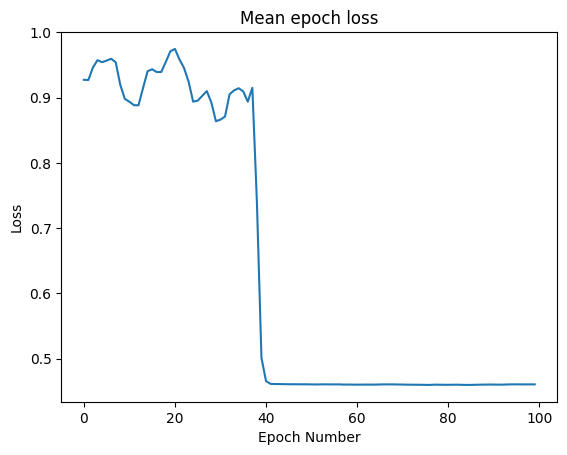

In [20]:
mean_losses = [mean(x) for x in losses]
mean_losses

plt.plot(list(range(len(mean_losses))), mean_losses)
plt.title('Mean epoch loss')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')

plt.show()

## We can compare our tuned model to the original model

In [ ]:
# Load up the model with default weights
sam_model_orig = sam_model_registry[model_type](checkpoint=checkpoint)
sam_model_orig.to(device);

In [ ]:
# Set up predictors for both tuned and original models
from segment_anything import sam_model_registry, SamPredictor
predictor_tuned = SamPredictor(sam_model)
predictor_original = SamPredictor(sam_model_orig)

In [ ]:
# The model has not seen keys[21] (or keys[20]) since we only trained on keys[:20]
k = keys[21]
image = cv2.imread(f'scans/scans/{k}.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

predictor_tuned.set_image(image)
predictor_original.set_image(image)

input_bbox = np.array(bbox_coords[k])

masks_tuned, _, _ = predictor_tuned.predict(
    point_coords=None,
    box=input_bbox,
    multimask_output=False,
)

masks_orig, _, _ = predictor_original.predict(
    point_coords=None,
    box=input_bbox,
    multimask_output=False,
)

We can see here that the tuned model is starting to ignore the whitespace between the words, which is what the ground truths show. With further training, more data and further hyperparameter tuning we will be able to improve this result.

If the image does not render due to size limitations, you can view it here https://drive.google.com/file/d/1ip5aryaxcp8JcEaZubL76oOM6srVzKsc/view?usp=sharing .

In [ ]:
%matplotlib inline
_, axs = plt.subplots(1, 2, figsize=(25, 25))


axs[0].imshow(image)
show_mask(masks_tuned, axs[0])
show_box(input_bbox, axs[0])
axs[0].set_title('Mask with Tuned Model', fontsize=26)
axs[0].axis('off')


axs[1].imshow(image)
show_mask(masks_orig, axs[1])
show_box(input_bbox, axs[1])
axs[1].set_title('Mask with Untuned Model', fontsize=26)
axs[1].axis('off')

plt.show()